# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [6]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tensorflow-datasets --user
# DON'T MISS TO RESTART THE KERNEL

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install grpcio
!pip install tensorflow-gpu==2.0.0 --upgrade --user

     |████████████████████████████████| 380.8MB 30kB/s s eta 0:00:01     |███████████████▏                | 180.2MB 52.5MB/s eta 0:00:04     |██████████████████▎             | 217.1MB 35.6MB/s eta 0:00:05
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# tfds versions after 3.2.1 require Tensorflow 2.1.0 --> might cause GPU availability to be 'false'
!pip install tensorflow-datasets==3.2.1 --upgrade --user

     |████████████████████████████████| 3.4MB 4.8MB/s eta 0:00:01


In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [27]:
# TODO: Make all other necessary imports.
import numpy as np
import pandas as pd
import json
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset = tfds.load('oxford_flowers102',  data_dir = "~/tensorflow_datasets", with_info=True)

# TODO: Create a training set, a validation set and a test set.
data, dataset_info = dataset
test = data.get('test')
train = data.get('train')
validate = data.get('validation')

I0514 22:48:29.698849 140053016581888 download_and_prepare.py:201] Running download_and_prepare for dataset(s):
oxford_flowers102
I0514 22:48:29.700363 140053016581888 dataset_info.py:358] Load dataset info from /root/tensorflow_datasets/oxford_flowers102/2.1.1
I0514 22:48:29.711022 140053016581888 download_and_prepare.py:139] download_and_prepare for dataset oxford_flowers102/2.1.1...
I0514 22:48:29.711339 140053016581888 dataset_builder.py:288] Reusing dataset oxford_flowers102 (/root/tensorflow_datasets/oxford_flowers102/2.1.1)
name: "oxford_flowers102"
description: "The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring\nin the United Kingdom. Each class consists of between 40 and 258 images. The images have\nlarge scale, pose and light variations. In addition, there are categories that have large\nvariations within the category and several very similar categories.\n\nThe dataset is divided into a training set, a validation set and a test set.\nT

## Explore the Dataset

In [5]:
n_test = dataset_info.splits['test'].num_examples
n_train = dataset_info.splits['train'].num_examples
n_validate = dataset_info.splits['validation'].num_examples
n_classes = dataset_info.features['label'].num_classes

# TODO: Get the number of examples in each set from the dataset info.
print(f"Number of training examples: {n_train}")
print(f"Number of validation examples: {n_validate}")
print(f"Number of testing examples: {n_test}")

# TODO: Get the number of classes in the dataset from the dataset info.
print(f"Number of classes: {n_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of testing examples: 6149
Number of classes: 102


In [6]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for item in train.take(3):
    image = item['image']
    label = item['label']
    print(image.shape)
    print(label)


(500, 667, 3)
tf.Tensor(72, shape=(), dtype=int64)
(500, 666, 3)
tf.Tensor(84, shape=(), dtype=int64)
(670, 500, 3)
tf.Tensor(70, shape=(), dtype=int64)


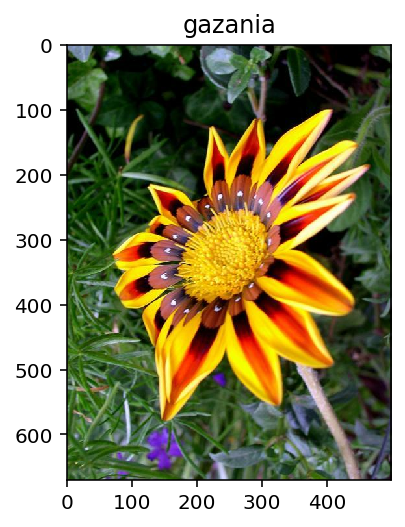

In [7]:
# TODO: Plot 1 image from the training set. 
class_names = dataset_info.features['label'].names

# Set the title of the plot to the corresponding image label. 
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
    
print(class_names.keys())

dict_keys(['21', '3', '45', '1', '34', '27', '7', '16', '25', '26', '79', '39', '24', '67', '35', '32', '10', '6', '93', '33', '9', '102', '14', '19', '100', '13', '49', '15', '61', '31', '64', '68', '63', '69', '62', '20', '38', '4', '86', '101', '42', '22', '2', '54', '66', '70', '85', '99', '87', '5', '92', '28', '97', '57', '40', '47', '59', '48', '55', '36', '91', '29', '71', '90', '18', '98', '8', '30', '17', '52', '84', '12', '11', '96', '23', '50', '44', '53', '72', '65', '80', '76', '37', '56', '60', '82', '58', '75', '41', '95', '43', '83', '78', '88', '94', '81', '74', '89', '73', '46', '77', '51'])


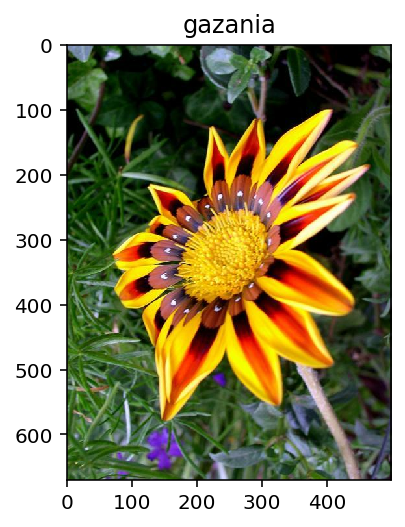

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
plt.imshow(image)
plt.title(class_names[str(label.numpy()+1)]) #The + 1 is because the keys in label_map are ordered starting at 1, not 0
plt.show()

## Create Pipeline

In [10]:
# TODO: Create a pipeline for each set.
batch_size = 32
image_size =224

def format_image(item):
    image = tf.image.resize(tf.cast(item['image'], tf.float32), (image_size, image_size)) / 255
    label = item['label']
    return image, label

training_batches = train.shuffle(n_train//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validate.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [11]:
# TODO: Build and train your network.

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(n_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
32/32 [==============================] - 13s 404ms/step - loss: 4.2424 - accuracy: 0.1147 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 6s 182ms/step - loss: 2.0812 - accuracy: 0.6814 - val_loss: 1.9915 - val_accuracy: 0.6559
Epoch 3/100
32/32 [==============================] - 6s 182ms/step - loss: 1.0912 - accuracy: 0.9088 - val_loss: 1.5351 - val_accuracy: 0.7206
Epoch 4/100
32/32 [==============================] - 6s 181ms/step - loss: 0.6574 - accuracy: 0.9676 - val_loss: 1.2931 - val_accuracy: 0.7657
Epoch 5/100
32/32 [==============================] - 6s 182ms/step - loss: 0.4389 - accuracy: 0.9843 - val_loss: 1.1647 - val_accuracy: 0.7784
Epoch 6/100
32/32 [==============================] - 6s 178ms/step - loss: 0.3176 - accuracy: 0.9941 - val_loss: 1.0704 - val_accuracy: 0.7931
Epoch 7/100
32/32 [==============================] - 6s 181ms/step - loss: 0.2328 - accuracy: 0.9971 - val_loss: 1.0083 - val_accurac

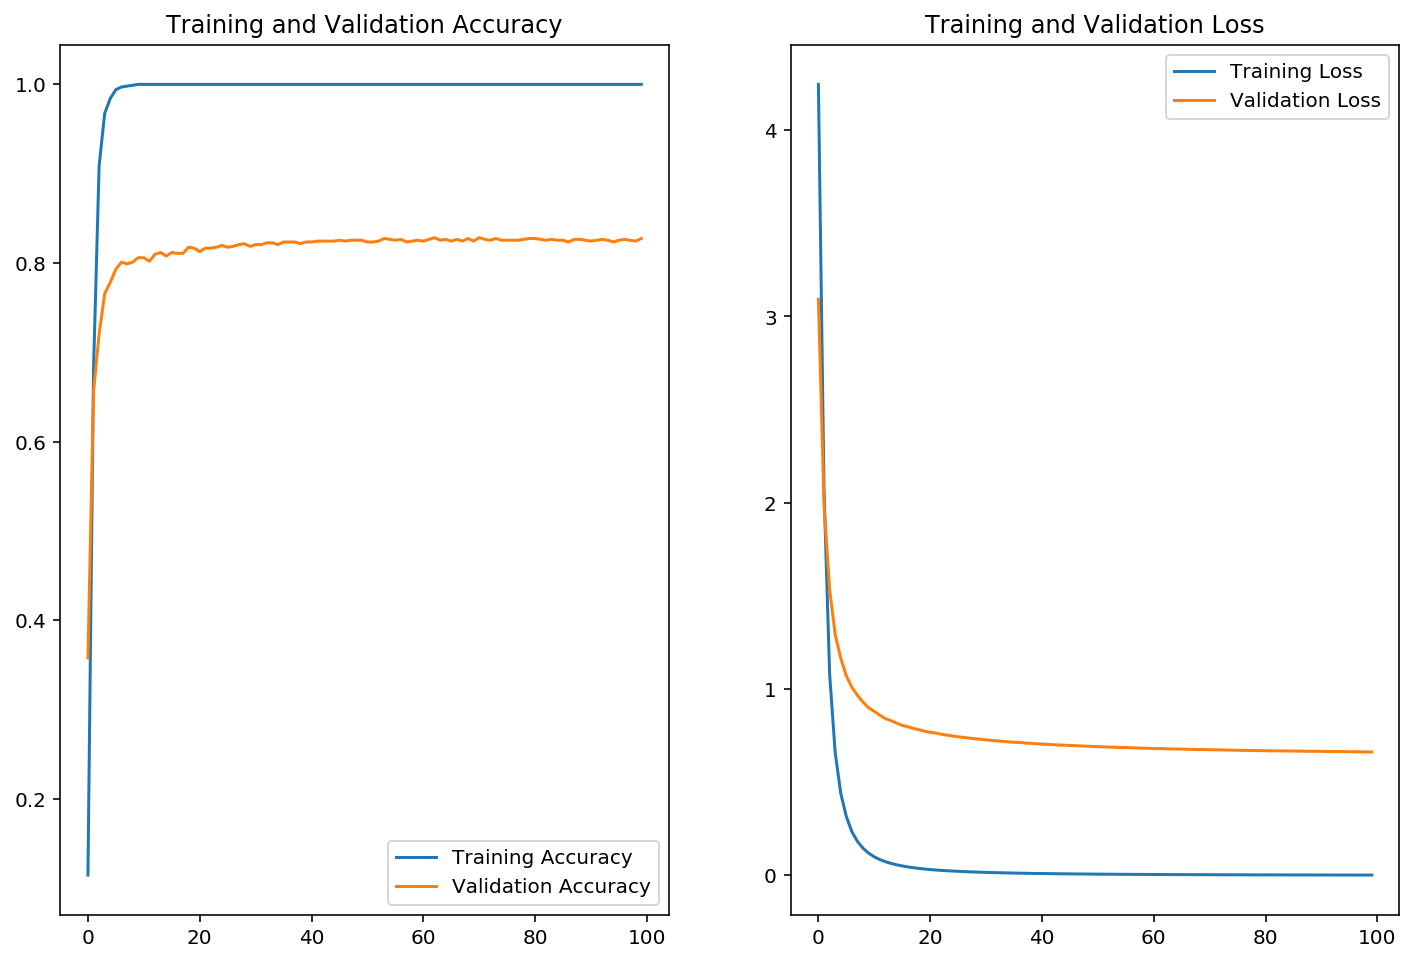

In [13]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(100)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [25]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 16s 85ms/step - loss: 0.8052 - accuracy: 0.7917

Loss on the TEST Set: 0.805
Accuracy on the TEST Set: 79.167%


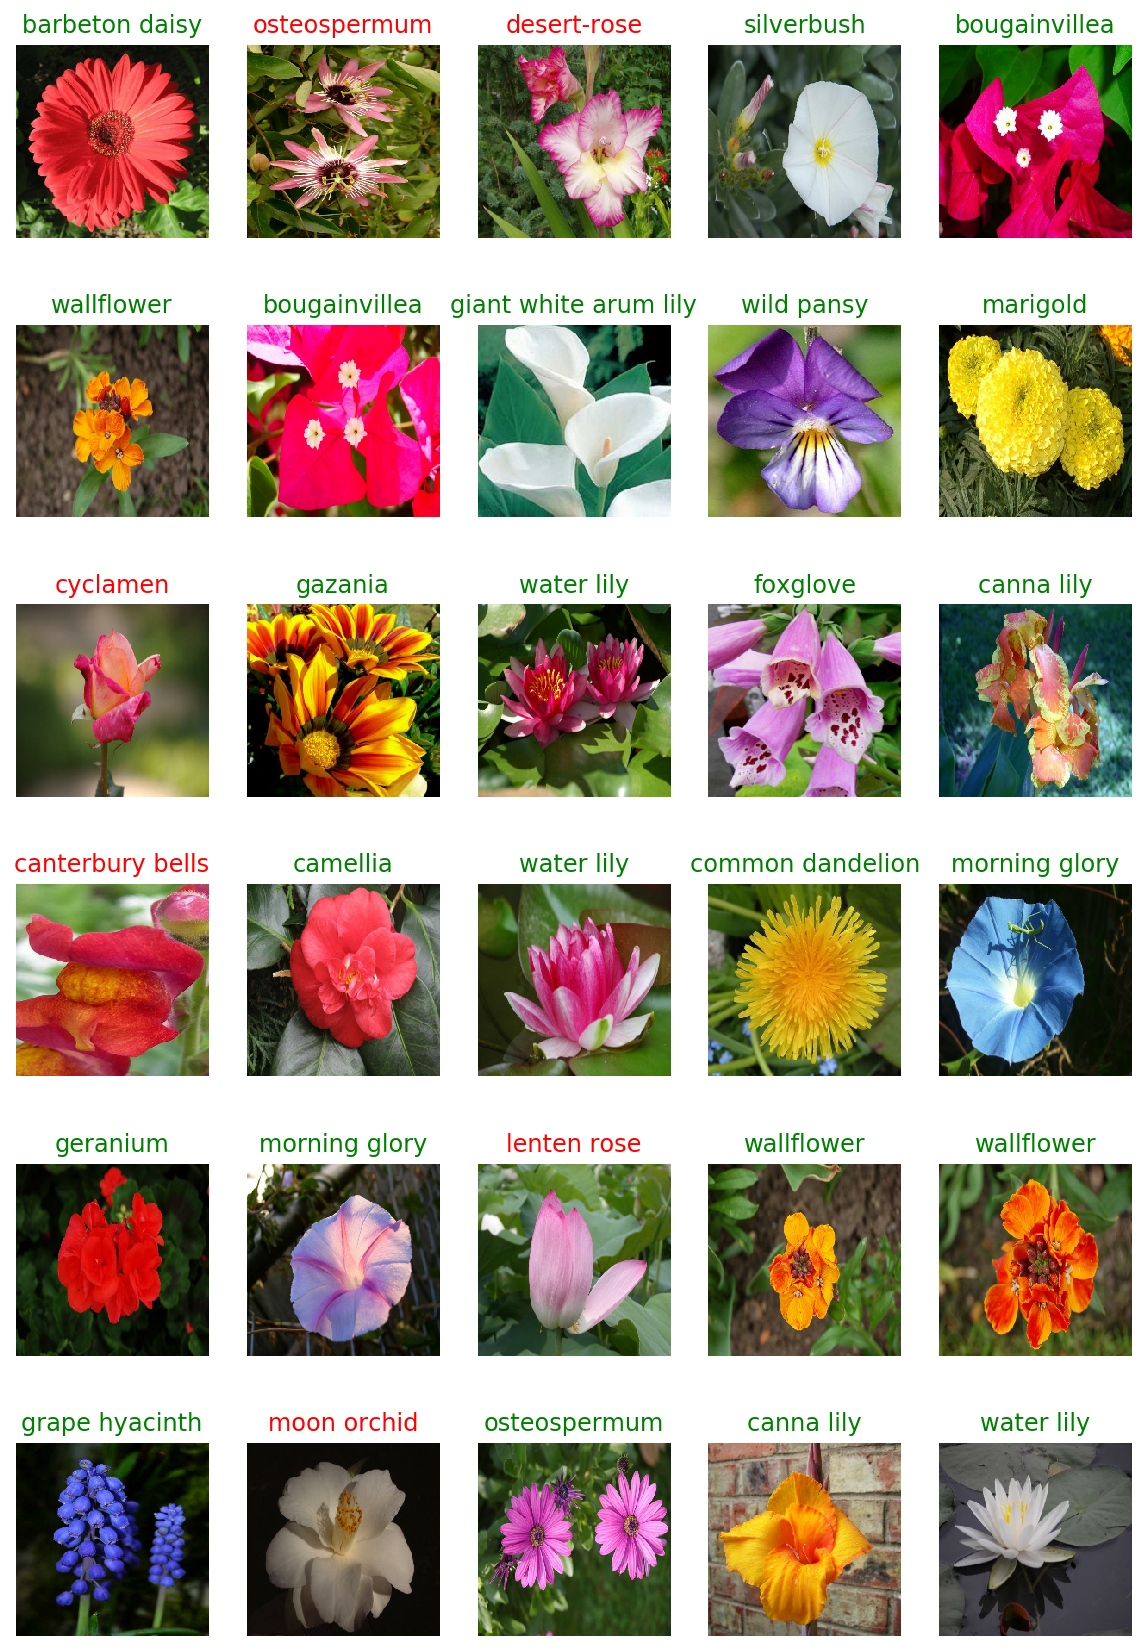

In [26]:
predictions = model.predict(testing_batches)

for image_batch, label_batch in testing_batches.take(1):
    test_images = image_batch.numpy().squeeze()
    test_labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(test_images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(predictions[n]) == test_labels[n] else 'red'
    plt.title(class_names[str(np.argmax(predictions[n])+1)], color=color)
    plt.axis('off')

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [28]:
# TODO: Save your trained model as a Keras model.

t = time.time()

path = './{}.h5'.format(int(t))

model.save(path)

In [32]:
t = time.time()

path = './{}.h5'.format(int(t))

tf.keras.experimental.export_saved_model(model, path)

INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./1621034604.h5/saved_model.pb


INFO:tensorflow:SavedModel written to: ./1621034604.h5/saved_model.pb


## Load the Keras Model

Load the Keras model you saved above.

In [33]:
# TODO: Load the Keras model
saved_path = './1621034604.h5'

loaded_model = tf.keras.experimental.load_from_saved_model(saved_path, custom_objects={'KerasLayer':hub.KerasLayer})
loaded_model.build((None, 224, 224, 3))

loaded_model.summary()

Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [36]:
# TODO: Create the process_image function
def process_image(image):
    tf_image = tf.convert_to_tensor(image)
    tf_image = tf.image.resize(tf_image, (224, 224))
    tf_image = tf.cast(tf_image, tf.float32)
    tf_image /= 255.
    return tf_image.numpy()


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

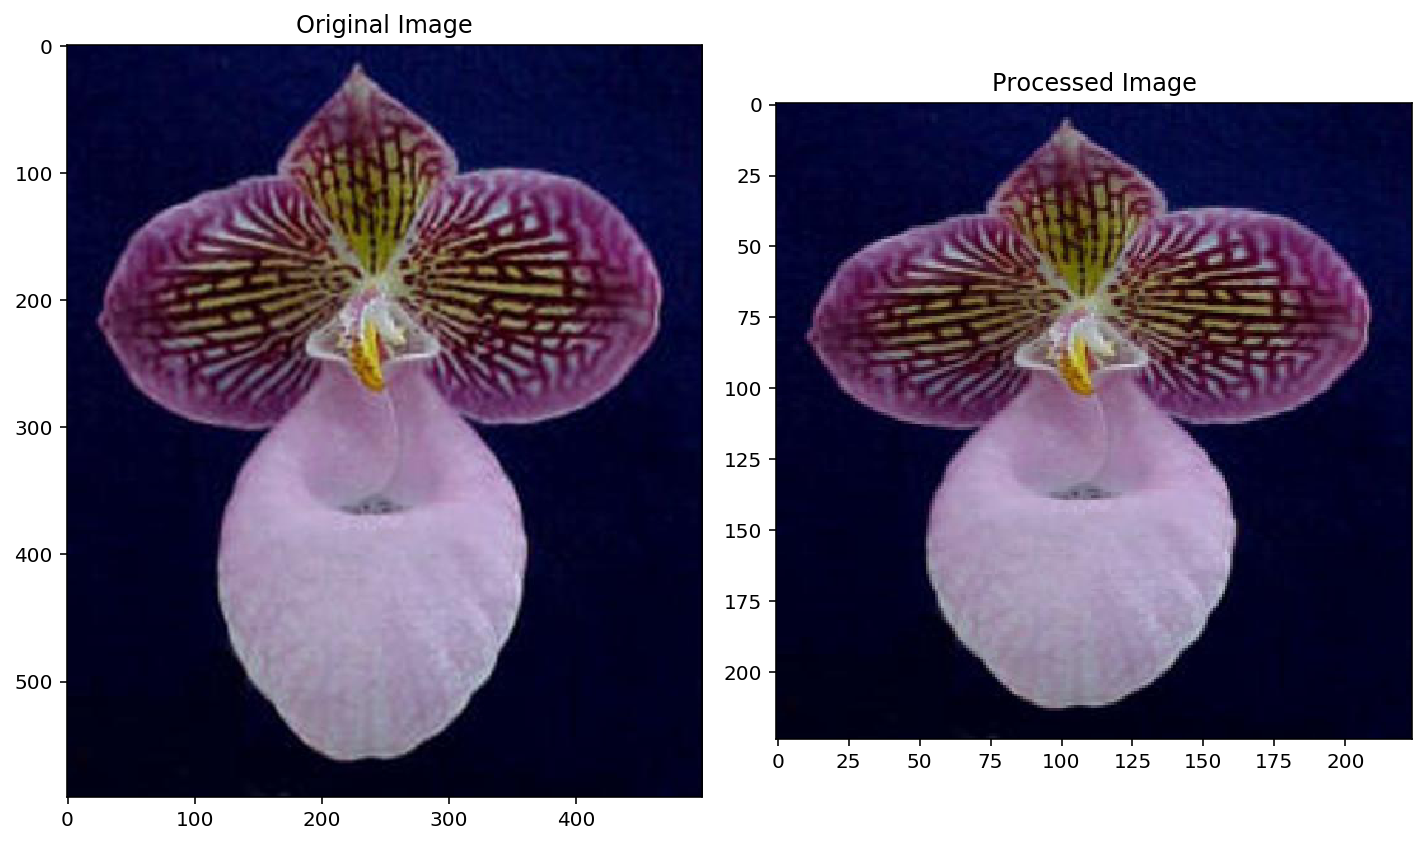

In [37]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [45]:
# TODO: Create the predict function
def predict(image_path, model, top_k):
    image = Image.open(image_path)
    processed_image = process_image(np.asarray(image))
    
    expanded_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(expanded_image)[0]
    int_labels = np.flip(np.argsort(prediction)) # gets the integer labels (0 to 101) from highest to lowest priority
    int_labels = int_labels[:top_k] # gets the highest top_k integer labels from highest to top_k-th highest priority
    classes = [str(i+1) for i in int_labels]
    
    probs = np.take(prediction, int_labels)
    return probs, classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [61]:
# TODO: Plot the input image along with the top 5 classes
#print(predict('./test_images/cautleya_spicata.jpg', loaded_model, 5))

def plot_prediction(image_path, image_name, model, top_k):
    my_image = Image.open(image_path)
    probs, classes = predict(image_path, model, top_k)
    class_labels = [class_names[label] for label in classes]
    
    fig, (ax1, ax2) = plt.subplots(figsize=(9,9), ncols=2)
    ax1.imshow(my_image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax1.set_title(image_name)
    ax2.barh(np.arange(top_k), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(top_k))
    ax2.set_yticklabels(class_labels, size='medium');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

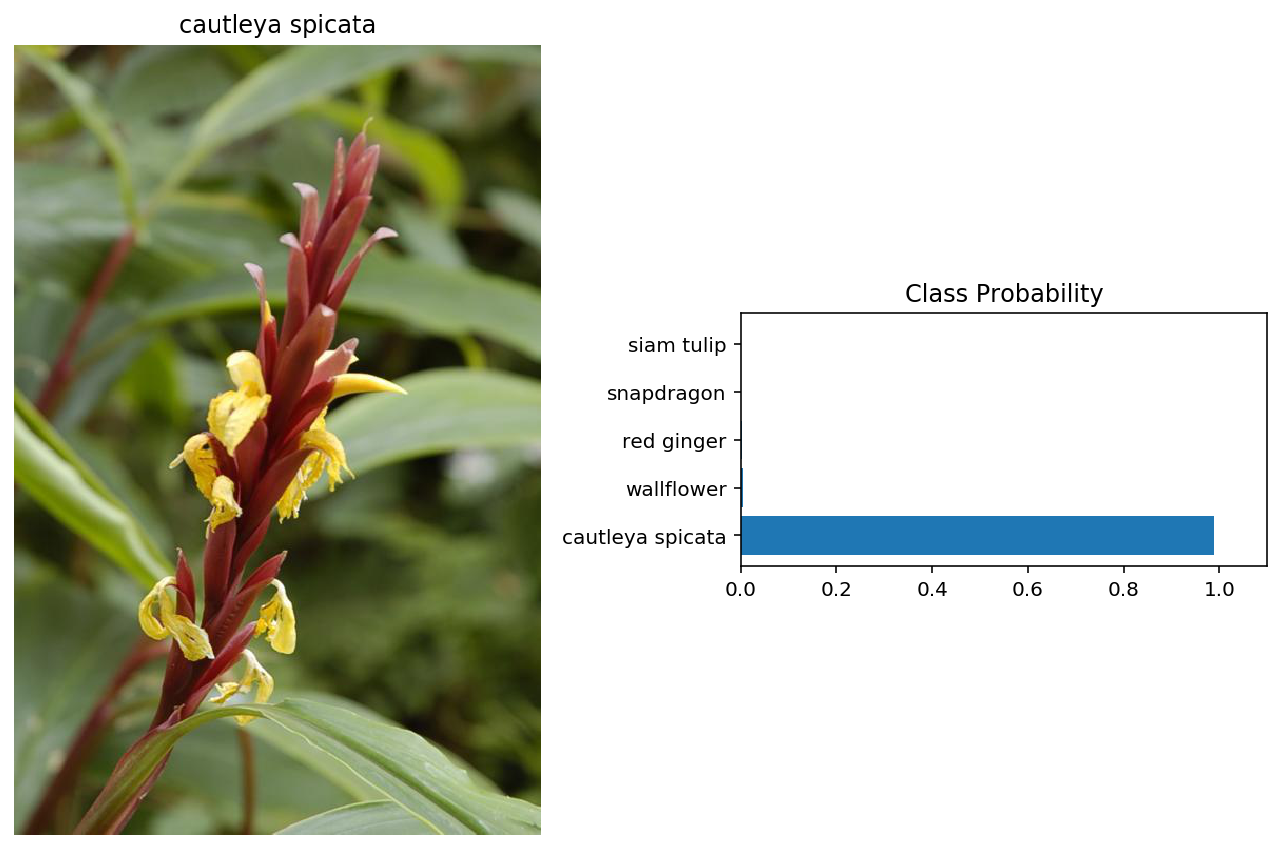

In [62]:
plot_prediction('./test_images/cautleya_spicata.jpg', 'cautleya spicata', loaded_model, 5)

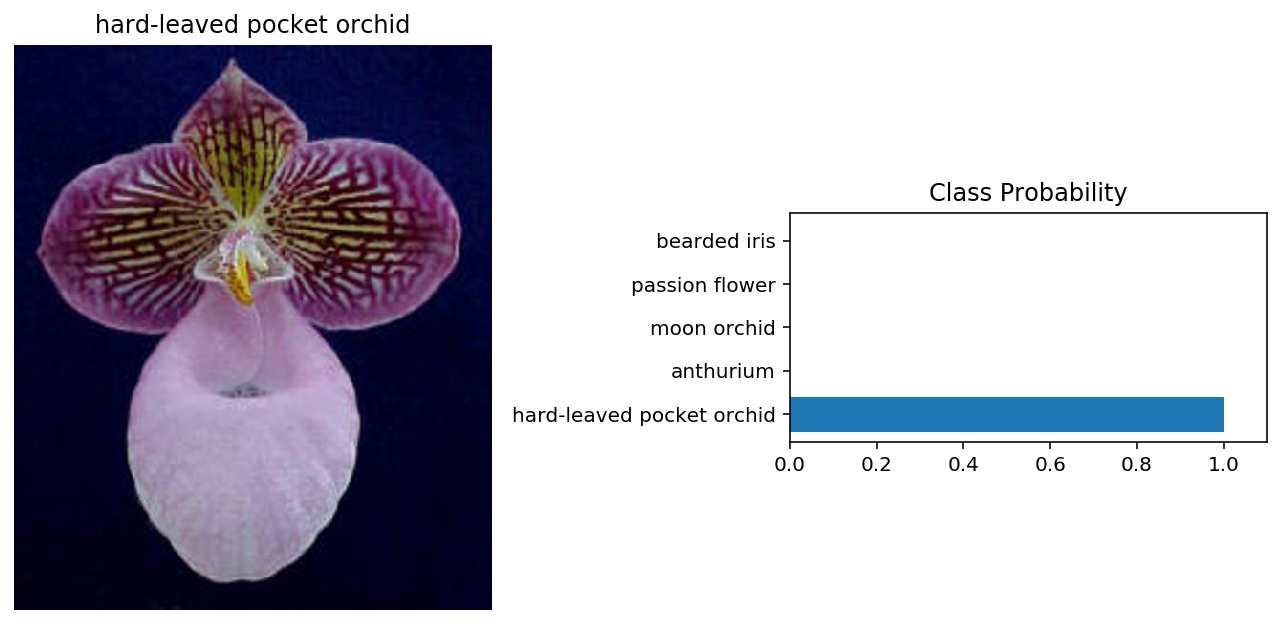

In [63]:
plot_prediction('./test_images/hard-leaved_pocket_orchid.jpg', 'hard-leaved pocket orchid', loaded_model, 5)

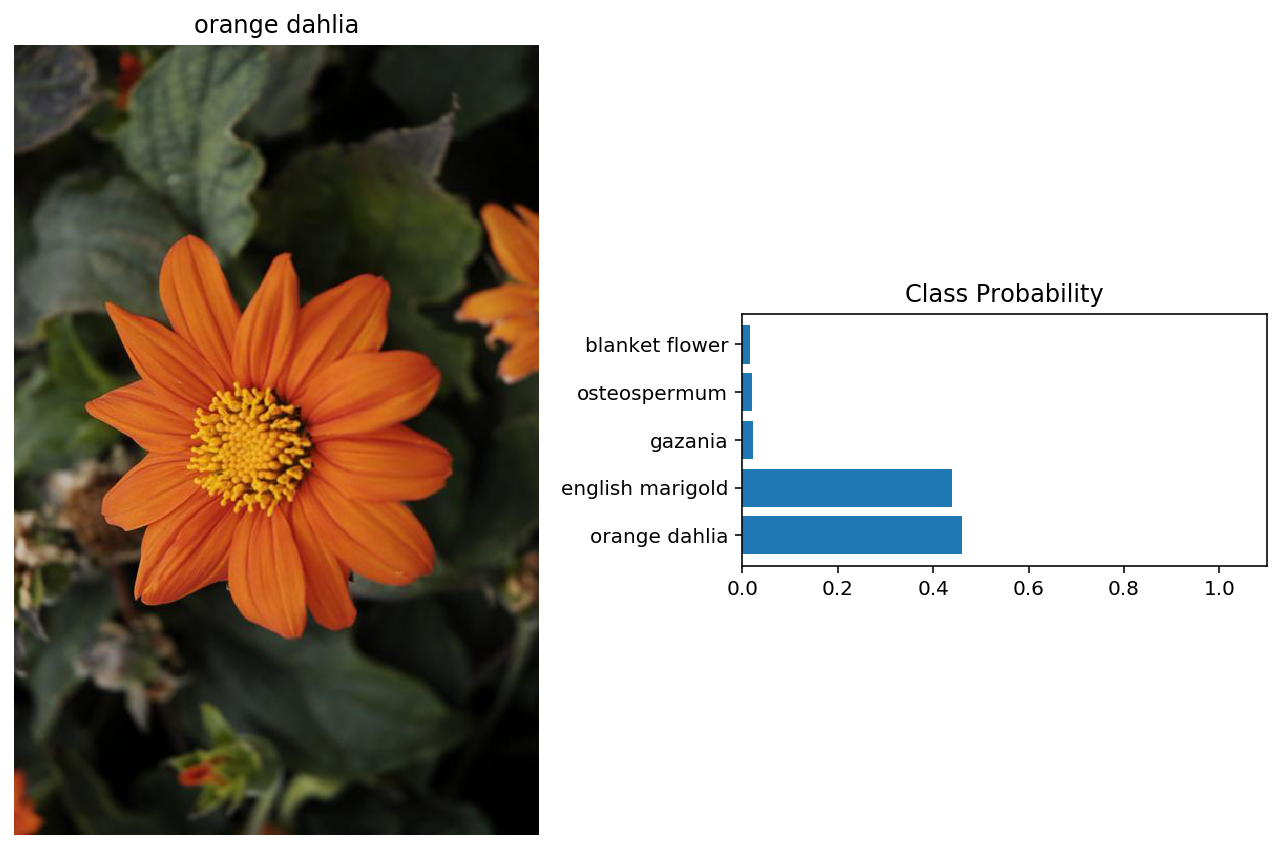

In [64]:
plot_prediction('./test_images/orange_dahlia.jpg', 'orange dahlia', loaded_model, 5)

In [ ]:
plot_prediction('./test_images/wild_pansy.jpg', 'wild pansy', loaded_model, 5)